In this notebook we try and calculate when does an eclipse occur based on observational data (position of sun, moon and earth) obtained from spicepy package -   
more information about it can be found here - https://naif.jpl.nasa.gov/naif/aboutspice.html

To summarize this notebook - we aim to findwhen did an eclipse (solar/lunar) occur in a given duration using the position of sun and moon  
We get radius of Moon and sun (planetary constants) and positional data (ephemeris) from NASA's SPICE python package  
then we calculate vectors for these objects from our point of observation and find the angular separation of the two objects and their angular size as seen from our point of observation   
using their separation and size we calculate an overlap fraction and classify the eclipse

### Imports

In [1]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
import math


https://naif.jpl.nasa.gov/naif/Ancillary_Data_Production_v2.pdf

In [2]:
# https://naif.jpl.nasa.gov/naif/aboutspice.html
import spiceypy as spice

### Constants

In [3]:
DEG = 180.0/np.pi #degrees #spice angles are in radians
MU_SUN = 1.32712440018e11  #km^3/s^2 #standard gravitational parameter of Sun

### Get Data

We load 3 files,   
leap seconds file (to find the time eclipse in earth times - as the clocks get corrected sometimes),   
planetary constants (for radius of planets so we can calculate apprent sizes) and   
ephemeris data (to find position of different celestial bodies)

In [4]:
# https://naif.jpl.nasa.gov/pub/naif/generic_kernels/pck/
# https://naif.jpl.nasa.gov/pub/naif/generic_kernels/lsk/

def load_kernels():
    spice.furnsh("../data/naif0012.tls")      # Leap seconds - conversion of earth time to ephemeris time
    spice.furnsh("../data/de440s.bsp")        # Ephemeris data - position and velocities
    spice.furnsh("../data/pck00011.tpc")      # Planetary constants - radius, spin axes, rotation rates etc.

### Get Apparent Distance between objects - Angle between 2 Vectors

This method defines how to get an angle between two vectors through a dot product - this gives us apparant separation between two celestial bodies as seen from a third body   
(e.g. we can take position of sun and moon as seen from earth - calculate the vectors and the angular separation between sun and moon as seen from earth)

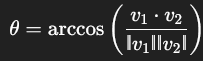

In [5]:
def get_angle_between_vectors(v1, v2):
    v1 = np.array(v1, dtype=float)
    v2 = np.array(v2, dtype=float)
    dot = np.dot(v1, v2)
    norm1 = np.linalg.norm(v1)
    norm2 = np.linalg.norm(v2)
    if norm1 == 0 or norm2 == 0:
        raise ValueError("One of the vectors has zero length")
    cos_theta = dot / (norm1 * norm2)
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    return np.arccos(cos_theta)
    # return spice.vsep(v1, v2)

### Get Apparent Size - Angular Radius

this method helps us determine how big a body of given radius looks from given distance by a second body 

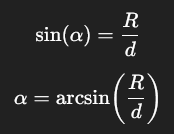

In [6]:
def get_angular_radius(radius_km, dist_km):
    x = max(0.0, min(1.0, radius_km / max(dist_km, 1e-9)))#values clamped [0,1]
    return math.asin(x)

### Get Radius

This method basically gets object radius from SPICE  
SPICE stores 3 radii (across x, y, z) - as things are not perfect spheres  
so we take a mean of the 3  

In [7]:
# https://naif.jpl.nasa.gov/pub/naif/toolkit_docs/IDL/icy/cspice_bodvrd.html
def get_mean_radius_km(body_name):
    radii = spice.bodvrd(body_name.upper(), "RADII", 3)[1]
    return float(np.mean(radii))

### Get State Vector

State vectors basically a vector concatenating position and velocity of a body in 3 cartesian coordinates w.r.t. another body  
This method uses the SPICE library to pass in object codes and get a vector representing the position and velocities of the bodies  

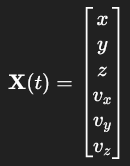

In [8]:
# codes for solar system bodies
# 10 - Sun, 399 - Earth, 301 - Moon
# https://naif.jpl.nasa.gov/pub/naif/toolkit_docs/C/req/naif_ids.html#Planets%20and%20Satellites

def get_state_vec(targ, obs, et, ref="J2000"):
    state, lt = spice.spkgeo(targ=targ, et=et, ref=ref, obs=obs)
    return np.array(state[:3])

### Get Angular Separation  

This method uses the above defined method to get the of sun and moon as observed from earth - at each point of time in a given time range  

In [9]:
def solar_moon_separation_over_range(start_date, end_date, step_hours=6):
    ets, seps_deg, dates = [], [], []
    t = start_date
    while t <= end_date:
        et = spice.utc2et(t.strftime("%Y-%m-%dT%H:%M:%S"))
        r_es = get_state_vec(10, 399, et)     # target sun  10 wrt Earth 399
        r_em = get_state_vec(301, 399, et)    # target moon 301 wrt Earth 399
        sep = get_angle_between_vectors(r_es, r_em) * DEG 
        ets.append(et); seps_deg.append(sep); dates.append(t)
        t += timedelta(hours=step_hours)
    return np.array(ets), np.array(seps_deg), dates

### Get Eclipse overlap 

This method calculates overlap between two objects by comparing their angular (apparent) separation and their angular (apparent) size

In [10]:
def circle_overlap_fraction(target_r, eclipsing_body_r, center_dist, eps=1e-12):
    r1, r2, d = float(target_r), float(eclipsing_body_r), float(center_dist)

    #distance between circles centers is greater than sum of radius (no touch)
    if d >= r1 + r2: 
        return 0.0
    #distance between circles is greater than diff of radius (total eclipse)
    # target body inside eclipsing body - eclipsing body is larger
    if d <= abs(r2 - r1) and r2 >= r1:
        return 1.0
    #distance between circles is less than diff of radius (partial eclipse on target)
    #eclipsing body inside target - eclipsing body is smaller 
    if d <= abs(r2 - r1) and r2 < r1:
        return (math.pi * r2**2) / (math.pi * r1**2)

    # Partial overlap
    # law of cosines (angles at which circles intersect))
    c1 = (d**2 + r1**2 - r2**2) / (2*d*r1 + eps)
    c2 = (d**2 + r2**2 - r1**2) / (2*d*r2 + eps)
    c1 = max(-1.0, min(1.0, c1)) # clip to [-1,1] to avoid fp issues
    c2 = max(-1.0, min(1.0, c2))

    # area of circular segments
    a1 = r1**2 * math.acos(c1)
    a2 = r2**2 * math.acos(c2)
    # area of triangle formed by circles centers and intersection points (Heron's)
    a3 = 0.5 * math.sqrt(max(0.0, (-d+r1+r2)*(d+r1-r2)*(d-r1+r2)*(d+r1+r2)))

    overlap_area = a1 + a2 - a3
    target_area = math.pi * r1**2
    return max(0.0, min(1.0, overlap_area / (target_area + eps)))

### Get Gamma 

This is a metric I added to compare with NASA's catalog metrics as seen here - https://eclipse.gsfc.nasa.gov/SEgoogle/SEgoogle2021.html  
this metric indicates the offset of the eclipse from earth's center

In [11]:
def compute_gamma_at_time(et):
    r_es = get_state_vec(10,  399, et)   # Sun wrt Earth
    r_em = get_state_vec(301, 399, et)   # Moon wrt Earth

    # Shadow axis direction at the Moon toward the sun in the Earth frame
    u = r_es - r_em                      # vector Moon - Sun in Earth frame
    u = u / np.linalg.norm(u)            # unit direction

    # Closest vector from the line (through r_em along u) to Earth's center (origin):
    # v = - u × (r_em × u)
    v = -np.cross(u, np.cross(u, r_em))
    # Sign: north (+) if v has positive component along J2000 +Z (Earth's north)
    sign = np.sign(np.dot(np.array([0.0, 0.0, 1.0]), v))

    Re_eq = get_mean_radius_km(body_name="EARTH")    
    gamma = sign * (np.linalg.norm(v) / Re_eq)
    return gamma

### Get Metrics

Algorithm -   
1 - Get Data  
          1.1 - Get Radius of Moon and sun rom NASA's SPICE python package (planetary constants)  
          1.2 - Get Sun and Moon positional data from NASA's SPICE python package (ephemeris)  
2 - Calculate position vectors for Sun and Moon wrt to Earth => (r_es, r_em)   
3 - Calculate the distance of sun & moon from earth => (d_es, d_em)     
4 - Calculate apparent size (angular radii) of sun and moon as seen from earth using their size R_sun, R_moon and distance from earth d_es, d_em => (a_sun, a_moon)  
4 - Calculate apparent separation between sun and moon as seen from earth using r_es and r_em => (sep)  
5 - Calculate fraction of overlap by comparing angular size of sun and moon a_sun, a_moon and their angular separation sep as seen from the earth => (frac)  
6 - Classify 

In [25]:
def get_solar_metrics_at_time(et):
    # radius of sun and moon in km
    R_sun  = get_mean_radius_km("SUN")
    R_moon = get_mean_radius_km("MOON")
    R_earth = get_mean_radius_km("EARTH")

    #position vectors for sun and moon wrt earth
    r_es = get_state_vec(10, 399, et)
    r_em = get_state_vec(301, 399, et)

    # distance of sun and moon from earth
    d_es = np.linalg.norm(r_es) 
    d_em = np.linalg.norm(r_em)  

    # apparent angular radius (size) of sun and moon from earth
    a_sun  = get_angular_radius(R_sun,  d_es)
    a_moon = get_angular_radius(R_moon, d_em)

    # apparent distance between sun and moon from earth
    sep = get_angle_between_vectors(r_es, r_em) #Only from geocenter

    # Anywhere from earth - Lunar horizontal parallax ≈ asin(R_earth / d_em)  (~57 arcmin)
    pi_E = math.asin(min(1.0, R_earth / max(d_em, 1e-9)))
    # We can reduce the geocenter separation by at most pi_E by choosing an optimalobserver on Earth's surface
    sep_global = max(0.0, sep - pi_E)

    # fraction of Sun's disk covered (planar small-angle approx)
    frac = circle_overlap_fraction(a_sun, a_moon, sep_global)

    if sep_global <= abs(a_moon - a_sun):
        if a_moon > a_sun: #if moon looks bigger than sun
            kind = "total"
        elif a_moon < a_sun: #if moon looks smaller than sun
            kind = "annular"
        else:
            kind = "exactly equal angular sizes"
    elif frac > 0: # partial eclipse
        kind = "partial"
    else:
        kind = "no eclipse"

    gamma = compute_gamma_at_time(et)

    return {
        "sun_obscuration_fraction": frac,     
        "sep_deg": sep * DEG,
        "alpha_sun_deg": a_sun * DEG,
        "alpha_moon_deg": a_moon * DEG,
        "classification": kind,
        "gamma": gamma
    }


The calculation of lunar eclipse is similar to that of a solar one - the only difference is we change our point of observation to be on the moon and then calculate overlap between earth and sun

In [26]:
def get_lunar_metrics_at_time(et):
    # radius of sun and moon in km
    R_earth = get_mean_radius_km("EARTH")
    R_sun   = get_mean_radius_km("SUN")
    R_moon  = get_mean_radius_km("MOON")

    # position vectors for sun and earth wrt moon
    r_em = get_state_vec(301, 399, et)  # Moon wrt Earth
    r_es = get_state_vec(10,  399, et)  # Sun  wrt Earth
    r_ms = get_state_vec(10, 301, et)   # Sun wrt Moon
    d_ms = np.linalg.norm(r_ms)
    d_me = np.linalg.norm(r_em)

    # apparent angular radius (size) of sun and earth from moon
    a_E = get_angular_radius(R_earth, d_me)
    a_S = get_angular_radius(R_sun, d_ms)

    # shadow angular radii (radians) (angular size of earth - sun)
    a_umb = max(0.0, a_E - a_S)
    a_pen = a_E + a_S
    # in km
    r_umb = d_me * math.tan(a_umb)
    r_pen = d_me * math.tan(a_pen)

    # offset between earth and sun poditiond from moon (radians)
    theta = get_angle_between_vectors(r_em, -r_ms)
    # in km
    s = d_me * theta

    # fractions of the Moon's disk covered
    frac_umb = circle_overlap_fraction(R_moon, r_umb, s) if r_umb > 0 else 0.0
    frac_pen = circle_overlap_fraction(R_moon, r_pen, s)
    # along diameter - negative umbral magnitude => no umbral contact; >1 => total (Moon fully within umbra)
    umbral_mag    = (r_umb + R_moon - s) / (2.0 * R_moon)
    penumbral_mag = (r_pen + R_moon - s) / (2.0 * R_moon)

    if frac_umb >= 1.0:
        kind = "total lunar eclipse (Moon fully in umbra)"
    elif frac_umb > 0:
        kind = "partial lunar eclipse (Moon partially in umbra)"
    elif frac_pen > 0:
        kind = "penumbral lunar eclipse (Moon only in penumbra)"
    else:
        kind = "no lunar eclipse"

    return {
        "umbra_fraction_of_moon": frac_umb,   
        "penumbra_fraction_of_moon": frac_pen,
        "theta_deg": theta * DEG,
        "alpha_earth_deg": a_E * DEG,
        "alpha_sun_deg": a_S * DEG,
        "classification": kind,
        "umbral_magnitude": umbral_mag,
        "penumbral_magnitude": penumbral_mag,
    }


# Get Eclipse Candidate in a time period

Now we just loop over a time period  
this loop also contains a condition to find duration and peak of the eclipse

In [27]:
def scan_solar_eclipses(start_dt, end_dt, step_size, min_obsc=0.01):
    t = start_dt
    events = []
    active = False
    current = None
    while t <= end_dt:
        et = spice.utc2et(t.strftime("%Y-%m-%dT%H:%M:%S"))
        m = get_solar_metrics_at_time(et)
        if m["sun_obscuration_fraction"] >= min_obsc:
            if not active:
                active = True
                current = {"start": t, "peak": (t, m), "peak_val": m["sun_obscuration_fraction"], "min_gamma": (t, m["gamma"], abs(m["gamma"]))}
            else:
                if m["sun_obscuration_fraction"] > current["peak_val"]:
                    current["peak"] = (t, m)
                    current["peak_val"] = m["sun_obscuration_fraction"]
                if abs(m["gamma"]) < current["min_gamma"][2]:
                    current["min_gamma"] = (t, m["gamma"], abs(m["gamma"]))
        elif active:
            current["end"] = t
            events.append(current)
            active = False
        t += step_size
    if active:
        current["end"] = end_dt
        events.append(current)
    return events

In [28]:
def scan_lunar_eclipses(start_dt, end_dt, step_size, min_umb_or_pen=0.01):
    t = start_dt
    events = []
    active = False
    current = None
    while t <= end_dt:
        et = spice.utc2et(t.strftime("%Y-%m-%dT%H:%M:%S"))
        m = get_lunar_metrics_at_time(et)
        measure = max(m["umbra_fraction_of_moon"], m["penumbra_fraction_of_moon"])
        if measure >= min_umb_or_pen:
            if not active:
                active = True
                current = {"start": t, "peak": (t, m), "peak_val": measure}
            else:
                if measure > current["peak_val"]:
                    current["peak"] = (t, m)
                    current["peak_val"] = measure
        elif active:
            current["end"] = t
            events.append(current)
            active = False
        t += step_size
    if active:
        current["end"] = end_dt
        events.append(current)
    return events

# RUN

In [29]:
load_kernels()
start = datetime(2024, 1, 1)
end   = datetime(2026, 12, 31)
step_size_solar = timedelta(minutes=5)
step_size_lunar = timedelta(hours=1)

solar_events = scan_solar_eclipses(start, end, step_size_solar, min_obsc=0.01)
print("SOLAR ECLIPSE CANDIDATES:")
for ev in solar_events:
    peak_t, peak_m = ev["peak"]
    print(f"{ev['start']} → {ev['end']} | peak @ {peak_t} | obsc={peak_m['sun_obscuration_fraction']:.3f} | {peak_m['classification'] }| gamma={peak_m['gamma']:.3f}")

lunar_events = scan_lunar_eclipses(start, end, step_size_lunar, min_umb_or_pen=0.01)
print("LUNAR ECLIPSE CANDIDATES:")
for ev in lunar_events:
    peak_t, peak_m = ev["peak"]
    print(f"{ev['start']} → {ev['end']} | peak @ {peak_t} | "
          f"umbra={peak_m['umbra_fraction_of_moon']:.3f}, pen={peak_m['penumbra_fraction_of_moon']:.3f} | {peak_m['classification']}| umbral_mag={peak_m['umbral_magnitude']:.3f}, penumbral_mag={peak_m['penumbral_magnitude']:.3f}")


SOLAR ECLIPSE CANDIDATES:
2024-04-08 15:45:00 → 2024-04-08 20:55:00 | peak @ 2024-04-08 16:40:00 | obsc=1.000 | total| gamma=-1.006
2024-10-02 15:50:00 → 2024-10-02 21:50:00 | peak @ 2024-10-02 16:55:00 | obsc=0.846 | annular| gamma=0.996
2025-03-29 08:55:00 → 2025-03-29 12:45:00 | peak @ 2025-03-29 10:50:00 | obsc=0.939 | partial| gamma=1.042
2025-09-21 17:35:00 → 2025-09-21 21:55:00 | peak @ 2025-09-21 19:45:00 | obsc=0.804 | partial| gamma=-1.067
2026-02-17 10:00:00 → 2026-02-17 14:30:00 | peak @ 2026-02-17 12:40:00 | obsc=0.922 | annular| gamma=-1.005
2026-08-12 15:40:00 → 2026-08-12 20:00:00 | peak @ 2026-08-12 17:00:00 | obsc=1.000 | total| gamma=1.000
LUNAR ECLIPSE CANDIDATES:
2024-03-25 05:00:00 → 2024-03-25 10:00:00 | peak @ 2024-03-25 07:00:00 | umbra=0.000, pen=0.962 | penumbral lunar eclipse (Moon only in penumbra)| umbral_mag=-0.161, penumbral_mag=0.924
2024-09-18 01:00:00 → 2024-09-18 05:00:00 | peak @ 2024-09-18 03:00:00 | umbra=0.014, pen=1.000 | partial lunar eclipse (

https://eclipse.gsfc.nasa.gov/SEgoogle/SEgoogle2021.html  
https://eclipse.gsfc.nasa.gov/LEdecade/LEdecade2021.html